# III. HÁZI FELADAT

Ezt a feladatsort Python nyelven kell megoldani. A kimeneti adatok ábrázolásához minden esetben használjuk a jupyter notebookot! Az ábrák legyenek áttekinthetőek, és szerepeljen rajtuk tengelyfelirat!

Az feladatok megoldásához szükség lesz az `ahkab` nevű áramkörszimulációs csomagra, és a `SchemDraw` nevű, kapcsolási rajzok készítésére szolgáló csomagra, melyek legfrissebb verziói `pip` segítségével installálhatók:

```
$ pip install git+https://github.com/ahkab/ahkab.git
$ pip install SchemDraw
```

# Passzív áramkörök numerikus vizsgálata

Lineáris, időben állandó fizikai rendszerek vizsgálatakor gyakran foglalkozunk ideális elektronikus áramkörökkel, hiszen az elméleti érdekességeken túl ezek a gyakorlatban is igen fontosak. Az alábbi feladatok passzív elektronikai alkatrészekből (ellenállás, kondenzátor és induktivitás) megépíthető áramkörök viselkedését vizsgálják, de az alkalmazott módszerek a jelfeldolgozás területén általánosan használhatók. A feladatok megoldása során az `ahkab` áramkörszimulációs csomagot használjuk, mely nagy időfelbontással számítja ki az áramkör egyes csomópontjaiban megjelenő jelalakokat (időfüggő feszültségeket). Az ilyen szimuláció közelebb áll a valódi analóg áramkörök működéséhez. A későbbiekben olyan, ún. diszkrét idejű rendszerekkel is fogalkozunk majd, melyek a digitális jelfeldolgozás modelljének tekinthetők.

A passzív elektronikai altrészek viselkedése a következő egyszerű fizikai törvényekkel írhatók le, ahol $u = u(t)$ az időfüggő feszültség, $i = i(t)$ az áram, $R$ az elleneállás, $C$ a kapacitás és $L$ az induktivitás:

* Ellenállás: $$ u = R i $$

* Kondenzátor: $$ \frac{du}{dt} = \frac{1}{C} i $$

* Induktivitás: $$ u = L \frac{di}{dt} $$

Konkrét áramkörök esetében az egyes komponensekre felírt differenciálegyenleteket a [Kirchhoff-törvények](https://hu.wikipedia.org/wiki/Kirchhoff-törvények) kapcsolják rendszerbe. Az egyenletek megoldásakor valamelyik bemeneti jelalakot (feszültség- vagy áramérték időbeli változását) előírjuk, és a rendszer erre adott válaszát, azaz egy kimeneti jelalak időfejlődését keressük.

Érdekes elméleti kérdés, hogy egy rendszer milyen választ ad egy nagyon rövid ideig tartó vizsgálóimpulzus esetében. Matematikailag az ilyen vizsgálóimpulzusokat Dirac-delta függvénnyel írjuk le, és ismert, hogy egy lineáris, időinvariáns rendszer válaszfüggvénye tetszőleges gerjesztés esetében meghatározható az **impulzusválasz** (más néven Green-függvény) és a gerjesztés konvolúciójaként:

$$
u_\mathrm{out}(t) = \int_{-\infty}^{t} u_\mathrm{in}(\tau) g(t-\tau) d\tau,
$$

ahol az, hogy az integrálás $t$-ig tart a rendszer kauzalitását fejezi ki.

Lineáris időinvariáns rendszereket érdemes Fourier-kifejtésben vizsgálni. Ilyekor a rendszer szinuszos bemenő gerjesztésekre adott válaszát keressük, ami a tranziens viselkedés lecsengése után a linearitás miatt azonos frekvenciájú, szintén szinuszos jelalak lesz. Egy rendszer **átviteli függvénye** megadja, hogy egy $f$ frekvenciájú szinuszos gerjesztés esetében a rendszer mekkora csillagpítást, illetve fázistolást okoz. Ismert, hogy Fourier-térben a konvolúció művelete a gerjesztés és az impulzusválasz Fourier-transzformáltjának szorzataként írható fel, és ebből az is következik, hogy az átviteli függvény az impulzusválasz Fourier-transzformáltja.

A feladatok során passzív áramköri elemekből összállított analóg szűrőket vizsgálunk, melyek az ún. Butterworth-topológiát követik. Az interneten elérhetők olyan eszközök, melyekkel különböző átviteli karakterisztikájú passzív vagy aktív szűrők tervezhetők, ld. pl.:    
    
* https://rf-tools.com/lc-filter/
* https://www.analog.com/designtools/en/filterwizard/

Az alábbi cellák olyan függvényeket definiálnak, melyek segítségével az ahkab programcsomag részletes ismerete nélkül is kiszámíthajuk néhány áramkör bemenő jelre adott válaszfüggvényét.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import ahkab
from ahkab import new_ac, run
from ahkab.circuit import Circuit
from ahkab import circuit, printing, time_functions

import SchemDraw as schem
import SchemDraw.elements as elem

In [2]:
def run_transient(circuit, fun, tstart=0, tstop=1e-2, tstep=1e-5):
    gnd = circuit.get_ground_node()
    circuit.add_vsource("V_in", n1="n_in", n2=gnd, dc_value=5, ac_value=1, function=fun)
    t = ahkab.new_tran(tstart=tstart, tstop=tstop, tstep=tstep, x0=None)
    r = ahkab.run(circuit, an_list=[t])
   
    time = r['tran']['T']
    source = fun(r['tran']['T'])
    response = r['tran']['Vn_out']
   
    circuit.remove_elem("V_in")
   
    return time, source, response

## Egyszerű aluláteresztő RC-kör

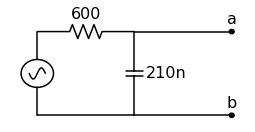

In [3]:
def rc_lowpass():
    c = circuit.Circuit(title="RC-tag")
    
    c.add_resistor("R1", n1="n_in", n2="n_out", value=600)
    c.add_capacitor("C1", n1="n_out", n2=c.gnd, value=210e-9)
    
    return c

def draw_rc_lowpass():
    d = schem.Drawing()
    V_in = d.add(elem.SOURCE_SIN, d='up')
    R = d.add(elem.RES, d='right', label='600')
    C = d.add(elem.CAP, d='down', botlabel='210n')
    d.add(elem.LINE, to=V_in.start)
    d.add(elem.LINE, d='right', xy=R.end)
    d.add(elem.DOT, label='a')
    d.add(elem.LINE, d='right', xy=C.end)
    d.add(elem.DOT, label='b')
    d.draw()
    
draw_rc_lowpass()

## 4-ed rendű Butterworth-féle aluláteresztő szűrő

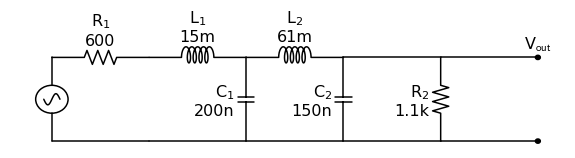

In [4]:
def butterworth_lowpass():
    c = circuit.Circuit(title="4-ed rendű Butterworth-féle aluláteresztő szűrő")
    
    c.add_resistor("R1", n1="n_in", n2="n2", value=600)
    c.add_inductor("L1", n1="n2", n2="n3", value=15e-3)
    c.add_capacitor("C1", n1="n3", n2=c.gnd, value=200e-9)
    c.add_inductor("L2", n1="n3", n2="n_out", value=61e-3)
    c.add_capacitor("C2", n1="n_out", n2=c.gnd, value=150e-9)
    c.add_resistor("R2", n1="n_out", n2=c.gnd, value=1.1e3)
    
    return c

def draw_butterworth_lowpass():
    d = schem.Drawing()
    
    V_in = d.add(elem.SOURCE_SIN, d='up')
    R1 = d.add(elem.RES, d='right', label='$R_1$\n600')
    L1 = d.add(elem.INDUCTOR2, d='right', label='$L_1$\n15m')
    C1 = d.add(elem.CAP, d='down', label='$C_1$\n200n')
    L2 = d.add(elem.INDUCTOR2, d='right', xy=C1.start, label='$L_2$\n61m')
    C2 = d.add(elem.CAP, d='down', label='$C_2$\n150n')
    d.add(elem.LINE, d='right', xy=C2.start)
    R2 = d.add(elem.RES, d='down', label='$R_2$\n1.1k')
    for i in range(4): d.add(elem.LINE, d='left')
    d.add(elem.LINE, d='right', xy=R2.start)
    d.add(elem.DOT, label='$V_\mathrm{out}$')
    d.add(elem.LINE, d='right', xy=R2.end)
    d.add(elem.DOT)
    
    d.draw()
    
draw_butterworth_lowpass()

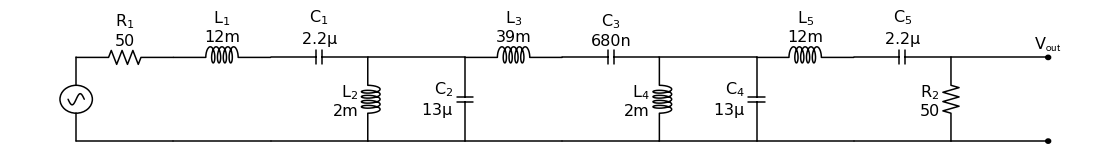

In [5]:
def butterworth_bandpass():
    c = Circuit('Butterworth-féle 1kHz-es sáváteresztő szűrő')
    
    c.add_resistor('R1', 'n_in', 'n2', 50.)
    c.add_inductor('L1', 'n2', 'n3', 12e-3)
    c.add_capacitor('C1', 'n3', 'n4', 2.2e-6)
    c.add_inductor('L2', 'n4', c.gnd, 2e-3)
    c.add_capacitor('C2', 'n4', c.gnd, 13e-6)
    c.add_inductor('L3', 'n4', 'n5', 39e-3)
    c.add_capacitor('C3', 'n5', 'n6', 680e-9)
    c.add_inductor('L4', 'n6', c.gnd, 2e-3)
    c.add_capacitor('C4', 'n6', c.gnd, 13e-6)
    c.add_capacitor('C5', 'n7', 'n_out', 2.2e-6)
    c.add_inductor('L5', 'n6', 'n7', 12e-3)
    c.add_resistor('R2', 'n_out', c.gnd, 50.)
    
    return c

def draw_butterworth_bandpass():
    d = schem.Drawing()
    
    V_in = d.add(elem.SOURCE_SIN, d='up')
    R1 = d.add(elem.RES, d='right', label='$R_1$\n50')
    L1 = d.add(elem.INDUCTOR2, d='right', label='$L_1$\n12m')
    C1 = d.add(elem.CAP, d='right', label='$C_1$\n2.2$\mu$')
    L2 = d.add(elem.INDUCTOR2, d='down', label='$L_2$\n2m')
    d.add(elem.LINE, d='right', xy=L2.start)
    C2 = d.add(elem.CAP, d='down', label='$C_2$\n13$\mu$')
    L3 = d.add(elem.INDUCTOR2, d='right', xy=C2.start, label='$L_3$\n39m')
    C3 = d.add(elem.CAP, d='right', label='$C_3$\n680n')
    L4 = d.add(elem.INDUCTOR2, d='down', label='$L_4$\n2m')
    d.add(elem.LINE, d='right', xy=L4.start)
    C4 = d.add(elem.CAP, d='down', label='$C_4$\n13$\mu$')
    L5 = d.add(elem.INDUCTOR2, d='right', xy=C4.start, label='$L_5$\n12m')
    C5 = d.add(elem.CAP, d='right', label='$C_5$\n2.2$\mu$')
    R2 = d.add(elem.RES, d='down', label='$R_2$\n50')
    for i in range(9): d.add(elem.LINE, d='left')
    d.add(elem.LINE, d='right', xy=R2.start)
    d.add(elem.DOT, label='$V_\mathrm{out}$')
    d.add(elem.LINE, d='right', xy=R2.end)
    d.add(elem.DOT)
    
    d.draw()
    
draw_butterworth_bandpass()

# Feladatok

## 1. feladat - Mérőjelek szimulációja

Analóg áramkörök kísérleti, szimulált és analitikus vizsgálatakor gyakran alkalmazunk ún. mérőjeleket. Írjunk függvényeket, melyek megvalósítják

* a tetszőleges frekvenciájú, amplitúdójú és fázisú szinuszos mérőjelet.
* a tetszőleges periódusidejű és amplitúdójú négyszögjelet.
* az egységimpulzust.
* az egységugrást.

Ábrázoljuk a mérőjeleket grafikonon. Interpoláció segítségével mintavételezzük a megvalósított mérőjeleket állandó időbeli felbontással. Milyen mintavételezési frekvencia szükséges egy $f$ frekvenciájú szinuszhullám mintavételezéséhez?

In [6]:
%pylab inline
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


#### Mérő jelek ábrázolása

In [7]:
# mérőjeleket megvalósítő függvények
def mero_sin(t = np.linspace(0, 2, 500), A = 1, f = 1000, phi = 0):
    jel = A*np.sin(2*np.pi*f*t+phi) # A amlitudó, f frekvencia, phi kezdőfázis
    return jel

def mero_negyszog(t = np.linspace(0, 2, 500), A = 1, f = 1000): # A 5 Hz waveform sampled at 500 Hz for 1 second:
    #jel = A * signal.square(2*np.pi*f*t) # A amlitudó, n periodusidő (T)
    jel2 = A * np.sign(np.sin(2*np.pi*f*t)) # A amlitudó, n periodusidő (T)
    #jel3 = [1 if int(2*np.pi*f*t)%2 == 0 else -1 for t in t]
    #return jel, jel2, jel3
    return jel2

def mero_egysegimp(t = np.linspace(-1, 1, 501), t0 = 0):
    #jel = signal.unit_impulse(len(t), 'mid')
    #jel = [1 if (t == 0) else 0]
    jel = (t == t0)+0 # bool type coercion to int
    return jel

def mero_egysegugras(t = np.linspace(-1, 1, 500), A = 1):
    jel = A*np.heaviside(t,0.5)
    #jel2 = (np.sign(t)+1)/2 # 0.5 0-ban
    #jel3 = [0 if t<0 else 1 if t>0 else 0.5 for t in t]
    #return jel, jel2, jel3    
    return jel

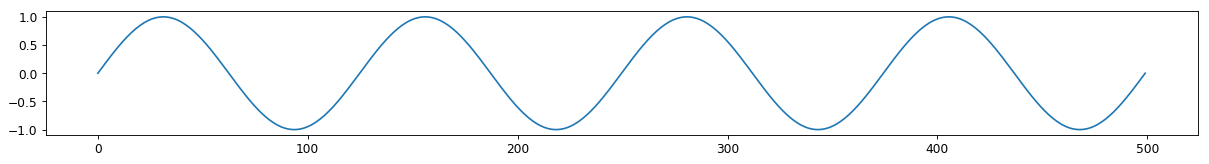

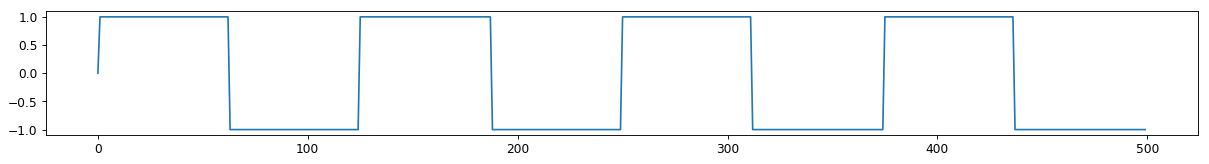

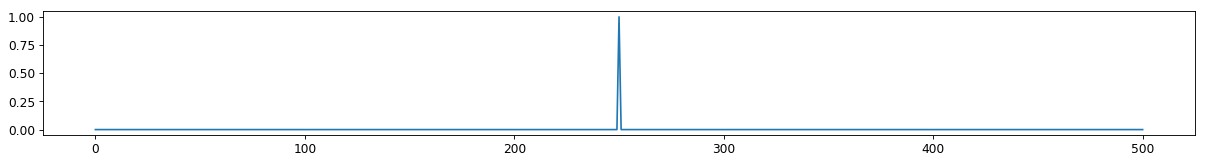

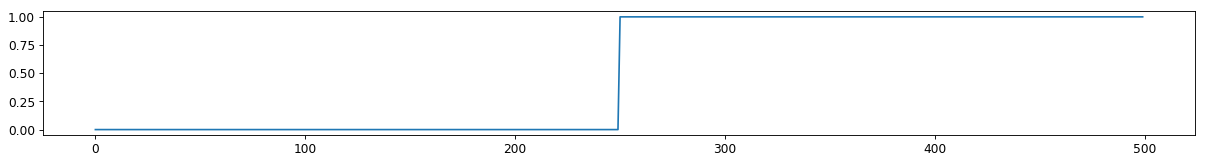

In [8]:
plt.figure(num=None, figsize=(16, 2), dpi=80, facecolor='w', edgecolor='k')  
plt.plot(mero_sin())
plt.figure(num=None, figsize=(16, 2), dpi=80, facecolor='w', edgecolor='k')  
plt.plot(mero_negyszog())
plt.figure(num=None, figsize=(16, 2), dpi=80, facecolor='w', edgecolor='k')  
plt.plot(mero_egysegimp())
plt.figure(num=None, figsize=(16, 2), dpi=80, facecolor='w', edgecolor='k')  
plt.plot(mero_egysegugras())

## 2. feladat - Mérőjelekre adott válaszok analízise

Szimuláljuk a mérőjelek hatását a fenti függvényekben definiált áramkörökre:

* Butterworth-féle aluláteresztő szűrő
* Butterworth-féle 1kHz-es sáváteresztő szűrő

Egységurás és impulzus esetén ügyeljünk arra, hogy a szimulált áramkörök viselkedését kiértékelő algoritmus csak folytonos, szakadással nem rendelkező függvények esetében működik, így célszerű a mérőjeleket az `interp1d` osztály segítségével "folytonossá" alakítani.

A paraméterezendő függvényeket legegyszerűbben ún. lambda kifejezésként adhatjuk át a tranziens viselkedést kiszámító `run_transient` függvénynek.

Az alábbi példa az RC-tag válaszfüggvényét mutatja 1kHz-es szinuszos gerjesztés esetén.

Text(0, 0.5, 'V')

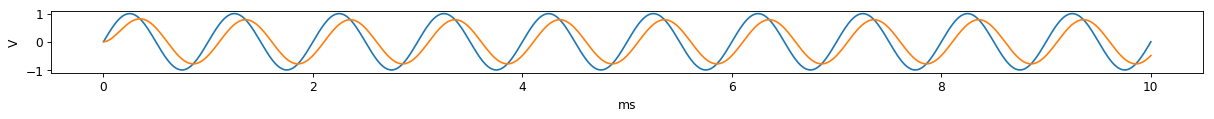

In [110]:
c = rc_lowpass()
t, s, r = run_transient(c, lambda t: np.sin(1000 * 2 * np.pi * t), tstart=0, tstop=10e-3)

plt.figure(num=None, figsize=(16, 1), dpi=80, facecolor='w', edgecolor='k')  
plt.plot(t * 1e3, s)
plt.plot(t * 1e3, r)
plt.xlabel("ms")
plt.ylabel("V")

#### RC lowpass szűrő

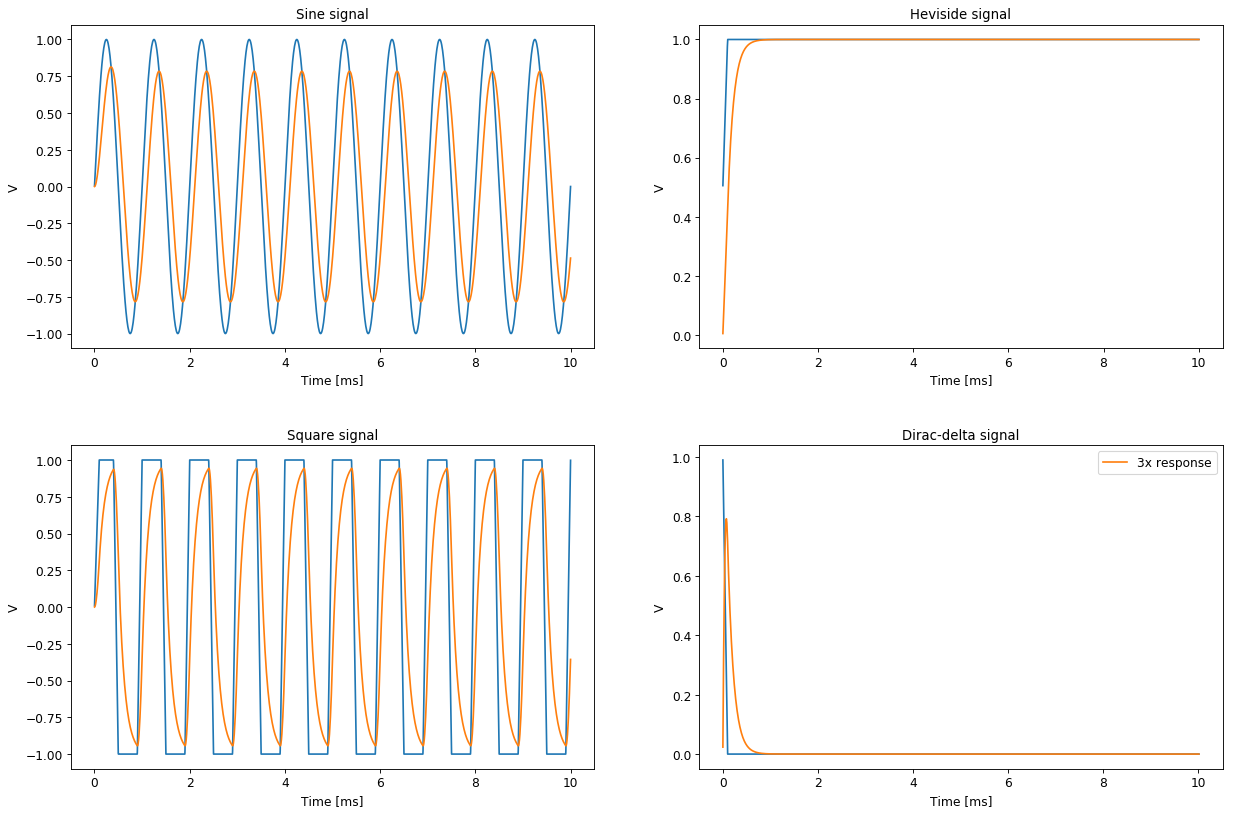

In [10]:
# Mérőjelek alkalmazása Butterworth-féle sáváteresztő szűrőre
c = rc_lowpass()

t = np.linspace(0,10,100000)

mero_negyszog_interp = interp1d(t,mero_negyszog(t), kind = 'linear')
mero_egysegimp_interp = interp1d(t,mero_egysegimp(t), kind = 'linear')
mero_egysegugras_interp = interp1d(t,mero_egysegugras(t), kind = 'linear')

t_sin, s_sin, r_sin = run_transient(c, lambda t:mero_sin(t), tstart=0, tstop=10e-3)
t_ugras, s_ugras, r_ugras = run_transient(c, mero_egysegugras_interp, tstart=0, tstop=10e-3)
t_imp, s_imp, r_imp = run_transient(c, mero_egysegimp_interp, tstart=0, tstop=10e-3)
t_negyszog, s_negyszog, r_negyszog = run_transient(c, mero_negyszog_interp, tstart=0, tstop=10e-3)

plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')  
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

plt.subplot(2, 2, 1)
plt.title("Sine signal")
plt.plot(t_sin * 1e3, s_sin)
plt.plot(t_sin * 1e3, r_sin)
plt.xlabel("Time [ms]")
plt.ylabel("V")

plt.subplot(2, 2, 2)
plt.title("Heviside signal")
plt.plot(t_ugras * 1e3, s_ugras)
plt.plot(t_ugras * 1e3, r_ugras)
plt.xlabel("Time [ms]")
plt.ylabel("V")

plt.subplot(2, 2, 3)
plt.title("Square signal")
plt.plot(t_negyszog * 1e3, s_negyszog)
plt.plot(t_negyszog * 1e3, r_negyszog)
plt.xlabel("Time [ms]")
plt.ylabel("V")

plt.subplot(2, 2, 4)
plt.title("Dirac-delta signal")
plt.plot(t_imp * 1e3, s_imp)
plt.plot(t_imp * 1e3, 3*r_imp, label='3x response')
plt.xlabel("Time [ms]")
plt.ylabel("V")
plt.legend()

#### Butterworth-féle sáváteresztő szűrő

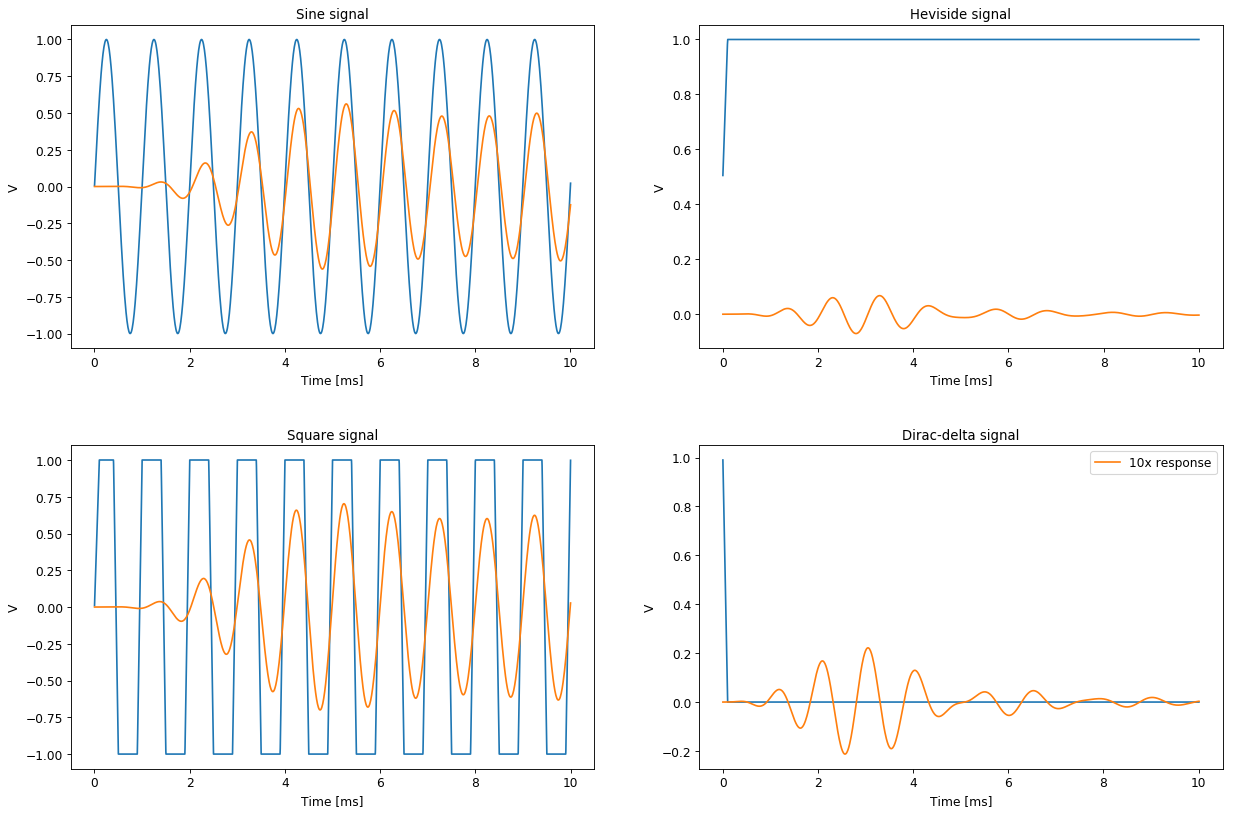

In [11]:
# Mérőjelek alkalmazása Butterworth-féle sáváteresztő szűrőre
c = butterworth_bandpass()

t = np.linspace(0,10,100000)

mero_negyszog_interp = interp1d(t,mero_negyszog(t), kind = 'linear')
mero_egysegimp_interp = interp1d(t,mero_egysegimp(t), kind = 'linear')
mero_egysegugras_interp = interp1d(t,mero_egysegugras(t), kind = 'linear')

t_sin, s_sin, r_sin = run_transient(c, lambda t:mero_sin(t), tstart=0, tstop=10e-3)
t_ugras, s_ugras, r_ugras = run_transient(c, mero_egysegugras_interp, tstart=0, tstop=10e-3)
t_imp, s_imp, r_imp = run_transient(c, mero_egysegimp_interp, tstart=0, tstop=10e-3)
t_negyszog, s_negyszog, r_negyszog = run_transient(c, mero_negyszog_interp, tstart=0, tstop=10e-3)

plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')  
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

plt.subplot(2, 2, 1)
plt.title("Sine signal")
plt.plot(t_sin * 1e3, s_sin)
plt.plot(t_sin * 1e3, r_sin)
plt.xlabel("Time [ms]")
plt.ylabel("V")

plt.subplot(2, 2, 2)
plt.title("Heviside signal")
plt.plot(t_ugras * 1e3, s_ugras)
plt.plot(t_ugras * 1e3, r_ugras)
plt.xlabel("Time [ms]")
plt.ylabel("V")

plt.subplot(2, 2, 3)
plt.title("Square signal")
plt.plot(t_negyszog * 1e3, s_negyszog)
plt.plot(t_negyszog * 1e3, r_negyszog)
plt.xlabel("Time [ms]")
plt.ylabel("V")

plt.subplot(2, 2, 4)
plt.title("Dirac-delta signal")
plt.plot(t_imp * 1e3, s_imp)
plt.plot(t_imp * 1e3, 10*r_imp, label='10x response')
plt.xlabel("Time [ms]")
plt.ylabel("V")
plt.legend()

#### Butterworth-lowpass sáváteresztő szűrő

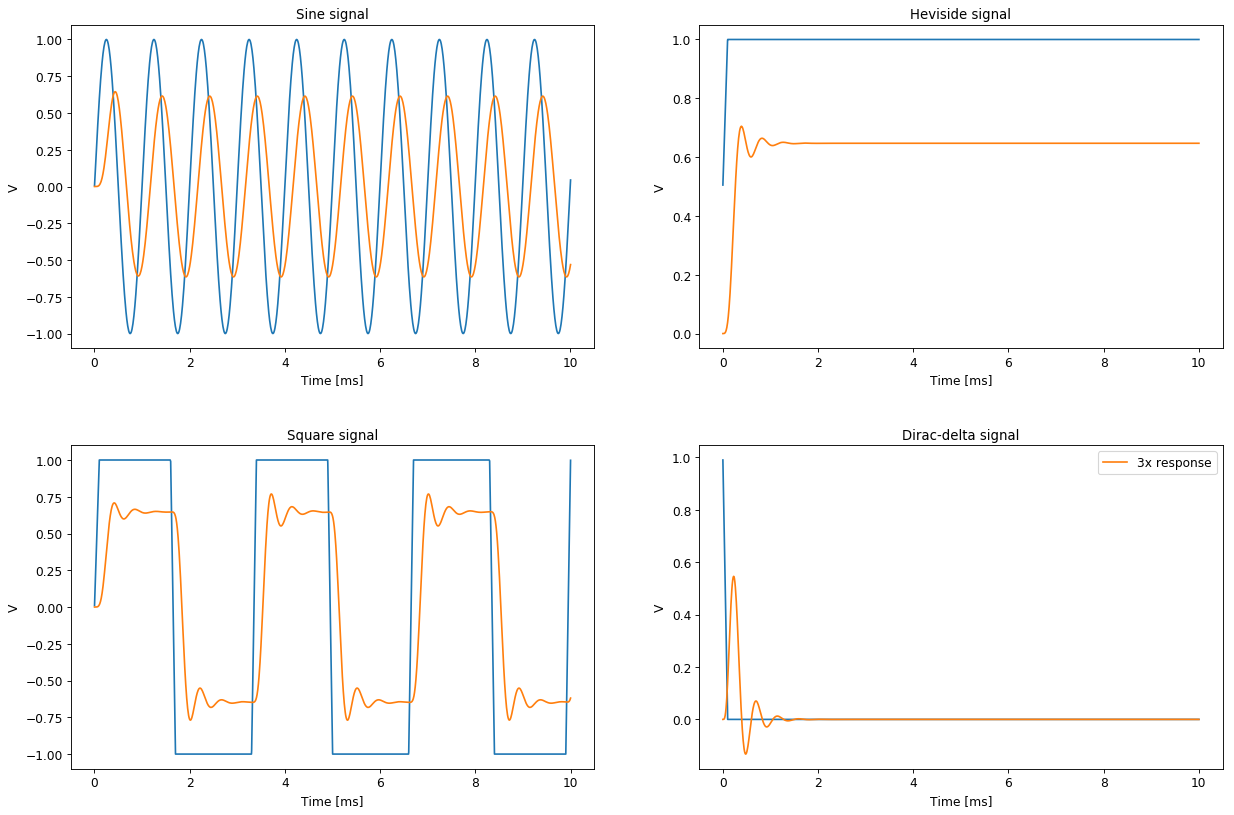

In [12]:
# Mérőjelek alkalmazása Butterworth-féle sáváteresztő szűrőre
# c = butterworth_bandpass()
# c = rc_lowpass()
c = butterworth_lowpass()

t = np.linspace(0,10,100000)

mero_negyszog_interp = interp1d(t,mero_negyszog(t, 1, 300), kind = 'linear')
mero_egysegimp_interp = interp1d(t,mero_egysegimp(t), kind = 'linear')
mero_egysegugras_interp = interp1d(t,mero_egysegugras(t), kind = 'linear')

t_sin, s_sin, r_sin = run_transient(c, lambda t:mero_sin(t), tstart=0, tstop=10e-3)
t_ugras, s_ugras, r_ugras = run_transient(c, mero_egysegugras_interp, tstart=0, tstop=10e-3)
t_imp, s_imp, r_imp = run_transient(c, mero_egysegimp_interp, tstart=0, tstop=10e-3)
t_negyszog, s_negyszog, r_negyszog = run_transient(c, mero_negyszog_interp, tstart=0, tstop=10e-3)

plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')  
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

plt.subplot(2, 2, 1)
plt.title("Sine signal")
plt.plot(t_sin * 1e3, s_sin)
plt.plot(t_sin * 1e3, r_sin)
plt.xlabel("Time [ms]")
plt.ylabel("V")

plt.subplot(2, 2, 2)
plt.title("Heviside signal")
plt.plot(t_ugras * 1e3, s_ugras)
plt.plot(t_ugras * 1e3, r_ugras)
plt.xlabel("Time [ms]")
plt.ylabel("V")

plt.subplot(2, 2, 3)
plt.title("Square signal")
plt.plot(t_negyszog * 1e3, s_negyszog)
plt.plot(t_negyszog * 1e3, r_negyszog)
plt.xlabel("Time [ms]")
plt.ylabel("V")

plt.subplot(2, 2, 4)
plt.title("Dirac-delta signal")
plt.plot(t_imp * 1e3, s_imp)
plt.plot(t_imp * 1e3, 3*r_imp, label='3x response')
plt.xlabel("Time [ms]")
plt.ylabel("V")
plt.legend()

## 3. feladat - Átviteli függvény meghatározása

Szimuláljuk a rendszer kimenetét különböző fkrevenciájú szinuszos bemenőjelek esetén. Határozzuk meg a kimenet amplitúdóját és fáziseltolódását a frekvencia függvényében. Ügyeljünk arra, hogy a kimeneti jel amplitúdóját a tranziens szakasz eltűnése után kell megmérni. Ábrázoljuk az átviteli függvényt.

In [96]:
# Átviteli függvény ábrázolása

def plot_amp_phase(tranz_end_ind, amplitude_maximum_index, amplitude_minimum_index, phase_null_signal, phase_null_response):
    plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')  
    plt.plot(t_sin * 1e3, r_sin)
    plt.annotate( "Tranziens szakasz vége", xy=(t_sin[tranz_end_ind] * 1e3,r_sin[tranz_end_ind]), 
                 xytext=(t_sin[1500] * 1e3, 60*r_sin[1500]), size=13,
                 arrowprops=dict(arrowstyle="->", connectionstyle = "angle,angleA=0,angleB=90,rad=10") )
    plt.plot(t_sin[amplitude_maximum_index] * 1e3,r_sin[amplitude_maximum_index],'ro',label='maximum')
    plt.plot(t_sin[amplitude_minimum_index] * 1e3,r_sin[amplitude_minimum_index],'ro',label='minimum')
    plt.title("Tranziens szakasszal")
    plt.xlabel("Time [ms]")
    plt.ylabel("V")
    plt.legend()

    plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')  
    plt.plot(t_sin[tranz_end_ind-500:] * 1e3, r_sin[tranz_end_ind-500:])
    plt.plot(t_sin[amplitude_maximum_index] * 1e3,r_sin[amplitude_maximum_index],'ro',label='maximum')
    plt.plot(t_sin[amplitude_minimum_index] * 1e3,r_sin[amplitude_minimum_index],'ro',label='minimum')
    plt.title("Tranziens szakasz után amplitudó")
    plt.xlabel("Time [ms]")
    plt.ylabel("V")
    plt.axhline(y=0, linewidth=1, color='#cccccc')
    plt.legend()

    plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')  
    plt.axvline(x=t_sin[phase_null_signal[0]+amplitude_minimum_index] * 1e3, linewidth=1, color='#cccccc')
    plt.axvline(x=t_sin[phase_null_response[0]+amplitude_minimum_index] * 1e3, linewidth=1, color='#cccccc')
    plt.axvline(x=t_sin[amplitude_minimum_index] * 1e3, linewidth=2, linestyle='--', color='#c7c7c7')
    plt.axvline(x=t_sin[amplitude_minimum_index+100] * 1e3, linewidth=2, linestyle='--', color='#c7c7c7')
    plt.axhline(y=0, linewidth=1, color='#cccccc')
    plt.plot(t_sin[tranz_end_ind:tranz_end_ind+500] * 1e3, 1100*r_sin[tranz_end_ind:tranz_end_ind+500], label="1100x Response signal")
    plt.plot(t_sin[phase_null_response[0]+amplitude_minimum_index] * 1e3,
             r_sin[phase_null_response[0]+amplitude_minimum_index],
             'o',color = '#2176B3' ,label='Response is equal to zero')
    plt.plot(t_sin[3000:3500] * 1e3, s_sin[3000:3500], label="Signal")
    plt.plot(t_sin[phase_null_signal[0]+amplitude_minimum_index] * 1e3,
             s_sin[phase_null_signal[0]+amplitude_minimum_index],
             'o',color = '#eb412d',label='Signal is equal to zero')
    plt.title("Tranziens szakasz utáni fázis eltolódás")
    plt.xlabel("Time [ms]")
    plt.ylabel("V")
    plt.legend()

In [97]:
# Átviteli függvény meghatározása
c = butterworth_bandpass()
t = np.linspace(0,60,10001)

t_sin, s_sin, r_sin = run_transient(c, lambda t:mero_sin(t, 1, 500, 0), tstart=0, tstop=5e-2)

In [98]:
tranz_end_ind = 3000
# Itt kinéztem a tranziens szakasz utáni indexet (3000) és utána néztem min, max értéket
amplitude_minimum_index = tranz_end_ind + [i for i, j in enumerate(r_sin[tranz_end_ind:]) if j == min(r_sin[tranz_end_ind:])][0]
amplitude_maximum_index = tranz_end_ind + [i for i, j in enumerate(r_sin[tranz_end_ind:]) if j == max(r_sin[tranz_end_ind:])][0]

# Itt nézem egy intervallumon a tranziens szakasz után, ahol jel és válasz egyenlő 0-val és
# ezeknek kapom vissza a ind, val párját
phase_null_signal = min(enumerate(s_sin[amplitude_minimum_index:amplitude_minimum_index+100]), key=lambda x: abs(x[1]-0))
phase_null_response = min(enumerate(r_sin[amplitude_minimum_index:amplitude_minimum_index+100]), key=lambda x: abs(x[1]-0))

In [99]:
amplitude_minimum_index, amplitude_maximum_index

(3135, 3435)

Kimenet amplitudója: 0.0017947760756472173 V
Kimenet fázis eltolódása: 21 ms


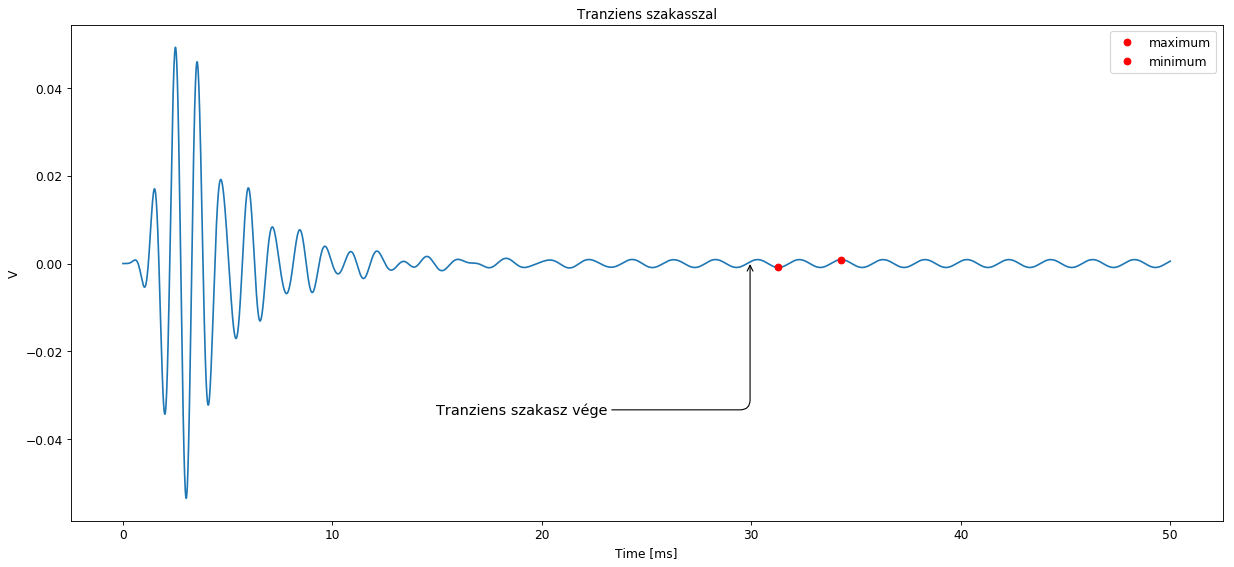

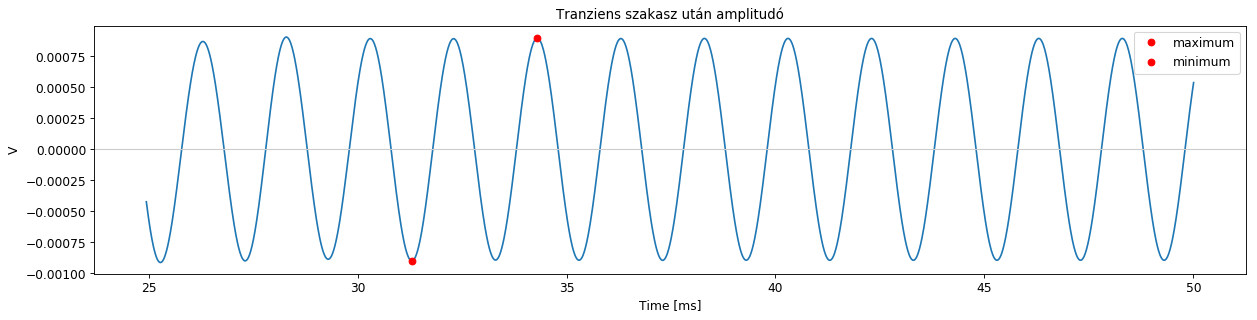

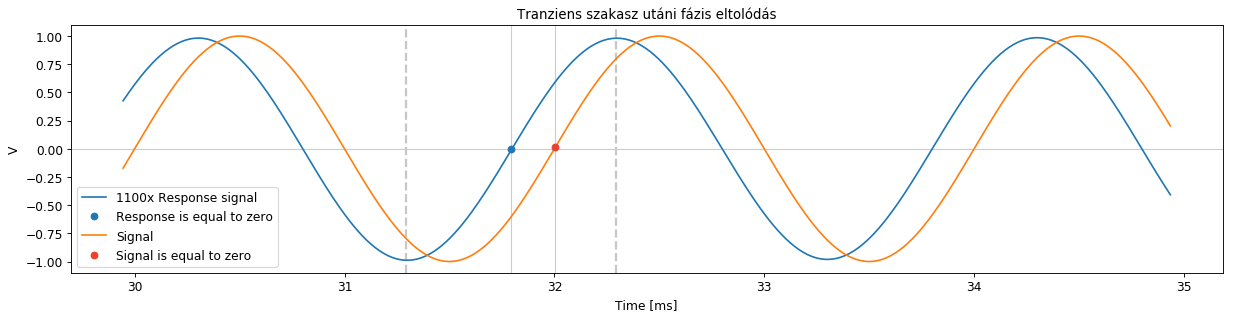

In [100]:
print("Kimenet amplitudója: " + str(abs(r_sin[amplitude_maximum_index])+abs(r_sin[amplitude_minimum_index])) + " V")
print("Kimenet fázis eltolódása: " + str(abs(phase_null_response[0]-phase_null_signal[0])) + " ms")
plot_amp_phase(tranz_end_ind, amplitude_maximum_index, amplitude_minimum_index, phase_null_signal, phase_null_response)


In [106]:
amplitude = []
phase = []
frequency = []
for i in range(0,900,5):
    t_sin, s_sin, r_sin = run_transient(c, lambda t:mero_sin(t, 1, 600+i, 0), tstart=0, tstop=5e-2)
    frequency.append(600+i)
    #tranz_end_ind = 3000
    # Itt kinéztem a tranziens szakasz utáni indexet (3000) és utána néztem min, max értéket
    amplitude_maximum_index = tranz_end_ind + [i for i, j in enumerate(r_sin[3000:]) if j == max(r_sin[3000:])][0]
    amplitude_minimum_index = tranz_end_ind + [i for i, j in enumerate(r_sin[3000:]) if j == min(r_sin[3000:])][0]
    amplitude.append(abs(r_sin[amplitude_maximum_index])+abs(r_sin[amplitude_minimum_index]))
    # Itt nézem egy intervallumon a tranziens szakasz után, ahol jel és válasz egyenlő 0-val és
    # ezeknek kapom vissza a ind, val párját
    phase_null_signal = min(enumerate(s_sin[amplitude_minimum_index:amplitude_minimum_index+100]), key=lambda x: abs(x[1]-0))
    phase_null_response = min(enumerate(r_sin[amplitude_minimum_index:amplitude_minimum_index+100]), key=lambda x: abs(x[1]-0))
    phase.append(abs(phase_null_response[0]-phase_null_signal[0]))
frequency_str = [str(x) for x in frequency]

Text(0, 0.5, 'V')

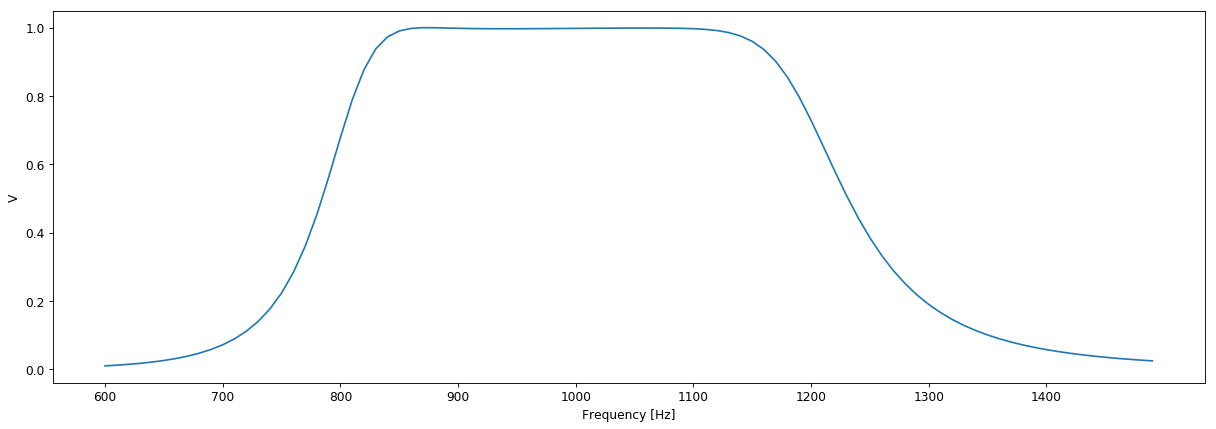

In [188]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(amplitude)
plt.xticks(range(0, len(frequency), 10), frequency_str[::10])
plt.xlabel('Frequency [Hz]')
plt.ylabel("V")

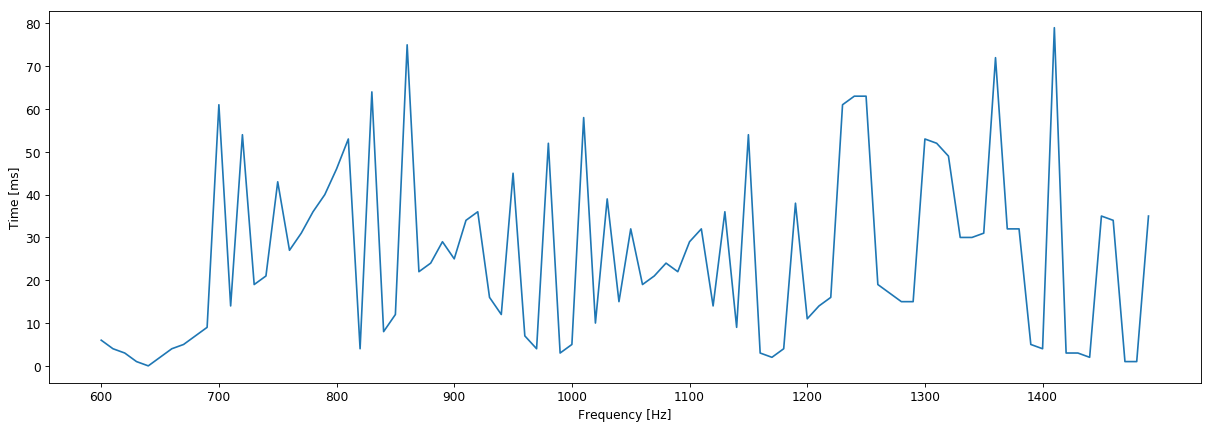

In [189]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(range(0, len(frequency), 10), frequency_str[::10])
plt.ylabel("Time [ms]")
plt.xlabel('Frequency [Hz]')
plt.plot(phase)

## 4. feladat - Az impulzusválasz tulajdonságainak vizsgálata

Szimuláljuk a fent használt sáváteresztő szűrő impulzusra adott válaszát. Mintavételezzük a válaszfüggvényt egyenletes időlépéssel, majd határozzuk meg a Fourier-transzformáltát. Hogyan viszonyul az impulzusválasz Fourier-transzformáltja az előző feladatban meghatározott átviteli függvényhez?

Interpoláljuk az impulzusválaszt egyenletes időfelbontású rácsra, majd határozzuk meg a Fourier-transzformáltját. Hasonlítsuk ezt össze a 3. feladatban meghatározott átviteli függvénnyel.

In [21]:
c = butterworth_bandpass()
t = np.linspace(-1,1,100001)
mero_egysegimp_interp = interp1d(t,mero_egysegimp(t), kind = 'linear')
t_imp, s_imp, r_imp = run_transient(c, mero_egysegimp_interp, tstart=-10e-3, tstop=5e-2)

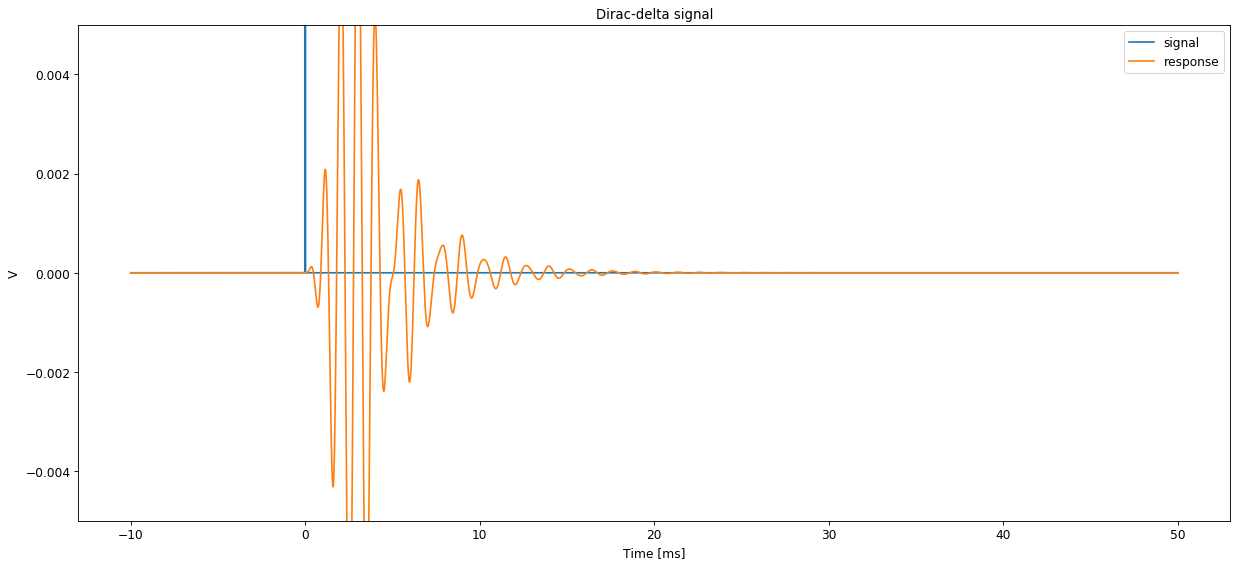

In [22]:
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')  
plt.title("Dirac-delta signal")
plt.plot(t_imp * 1e3, s_imp, label='signal')
plt.plot(t_imp * 1e3, r_imp, label='response')
plt.xlabel("Time [ms]")
plt.ylabel("V")
plt.ylim(-0.005,0.005)
plt.legend()

In [23]:
# Sáváteresztő szűrő impulzusválaszának Fourier-transzformáltja
r_imp_interp = interp1d(t_imp, r_imp, kind = 'linear')
s_imp_interp = interp1d(t_imp, s_imp, kind = 'linear')

tt = np.linspace(0,max(t_imp),1024)

fs = np.fft.rfft(s_imp_interp(tt))
fr = np.fft.rfft(r_imp_interp(tt))
freq = np.fft.rfftfreq(1024, tt[1] - tt[0])

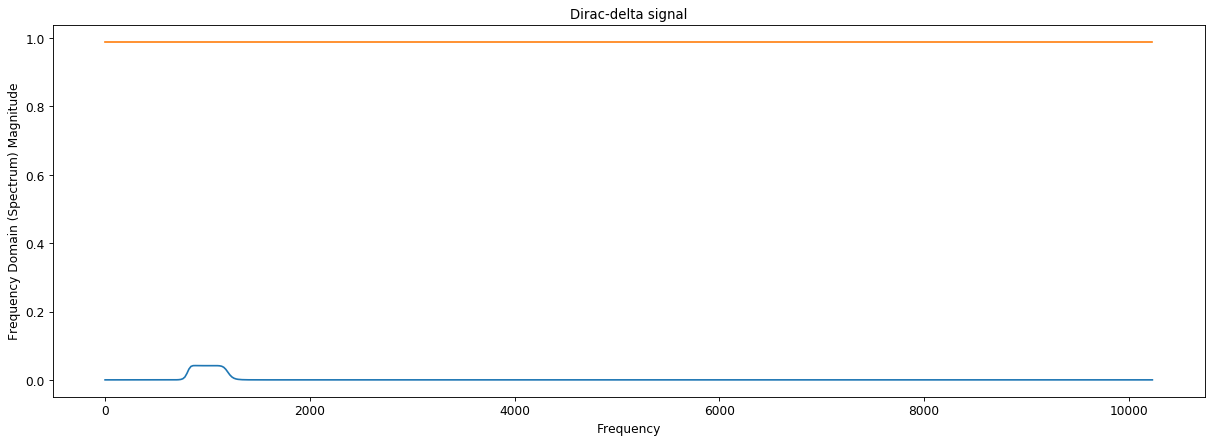

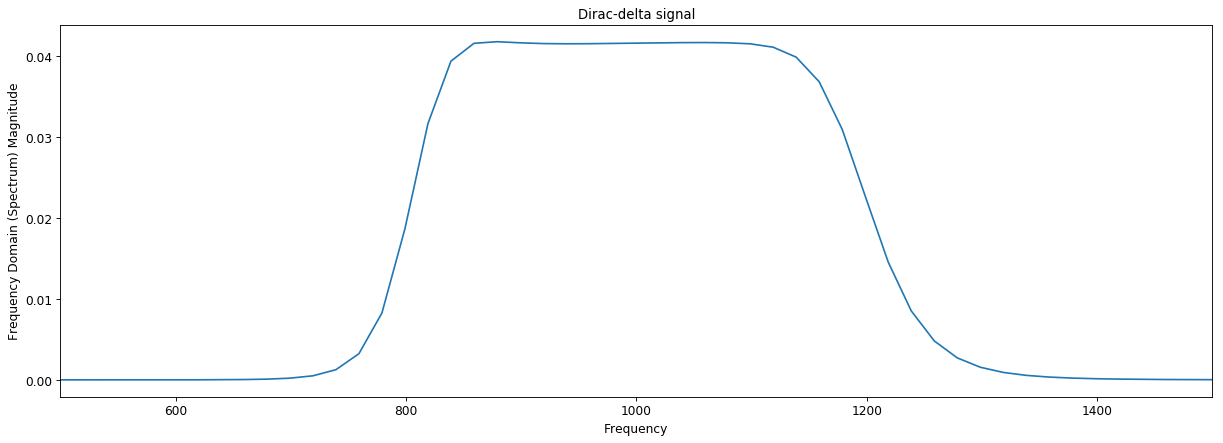

In [24]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Dirac-delta signal")
plt.xlabel('Frequency')
plt.ylabel('Frequency Domain (Spectrum) Magnitude')
plt.plot(freq, abs(fr)**2)
plt.plot(freq, abs(fs)**2)

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Dirac-delta signal")
plt.xlabel('Frequency')
plt.ylabel('Frequency Domain (Spectrum) Magnitude')
plt.xlim(500,1500)
plt.plot(freq, abs(fr)**2)

(500, 1500)

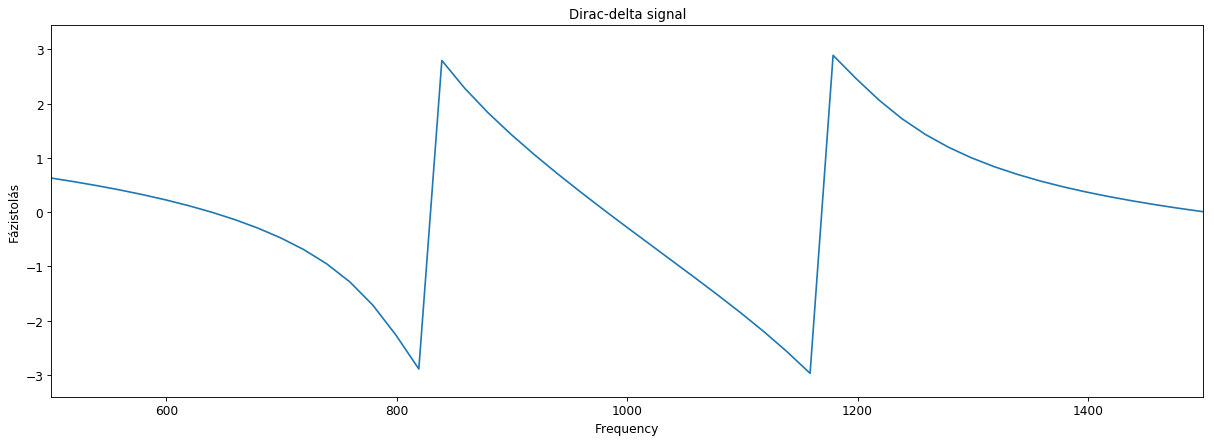

In [25]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Dirac-delta signal")
plt.xlabel('Frequency')
plt.ylabel('Fázistolás')
plt.plot(freq, arctan2(fr.imag, fr.real))
plt.xlim(500,1500)

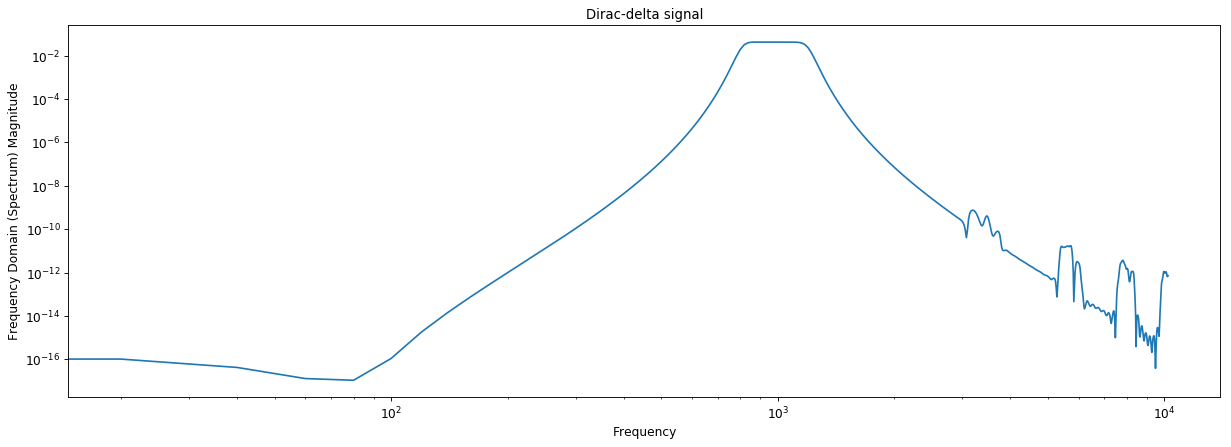

In [26]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Dirac-delta signal")
plt.xlabel('Frequency')
plt.ylabel('Frequency Domain (Spectrum) Magnitude')
plt.plot(freq, abs(fr)**2)
plt.yscale('log')
plt.xscale('log')

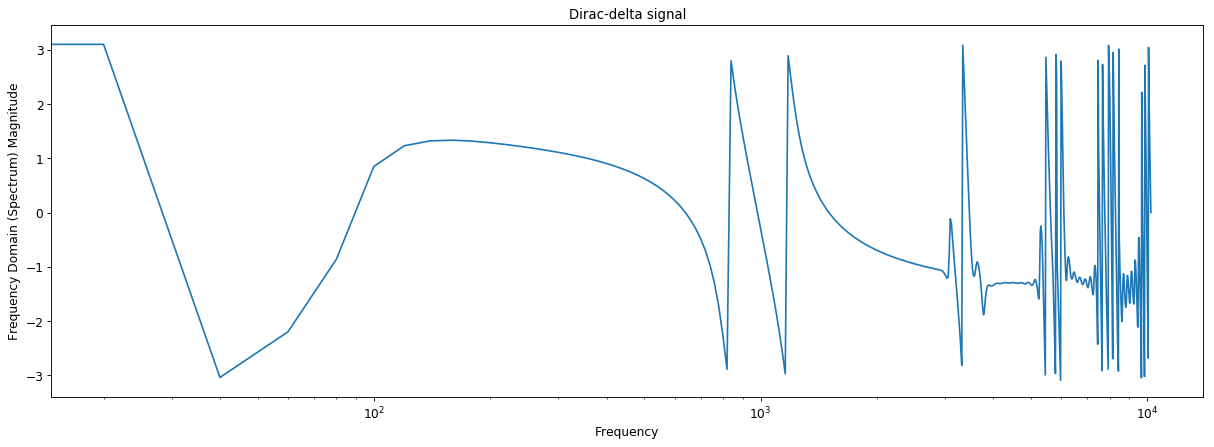

In [27]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Dirac-delta signal")
plt.xlabel('Frequency')
plt.ylabel('Frequency Domain (Spectrum) Magnitude')
plt.plot(freq, arctan2(fr.imag, fr.real))
plt.xscale('log')

Határozzuk meg az *aluláteresztő szűrő* impulzusválaszát, majd interpoláljuk időben egyenletes rácsra. Számoljuk ki a korábban már használt négyszögjel vagy más jelalak értékeit ugyanezen rácson. A `numpy.convolve` függvény segítségével számítsuk ki az impulzusválasz és a jelalak konvolúcióját. Hasonlítsuk ezt össze a 2. feladatban használt jelalakra kapott válasszal.

In [192]:
# Aluláteresztő szűrő impulzusválasza
# c = butterworth_bandpass()
# c = rc_lowpass()
c = butterworth_lowpass()

t = np.linspace(-1,1,100001)
mero_egysegimp_interp = interp1d(t,mero_egysegimp(t), kind = 'linear')
t_imp, s_imp, r_imp = run_transient(c, mero_egysegimp_interp, tstart=-10e-3, tstop=5e-2)

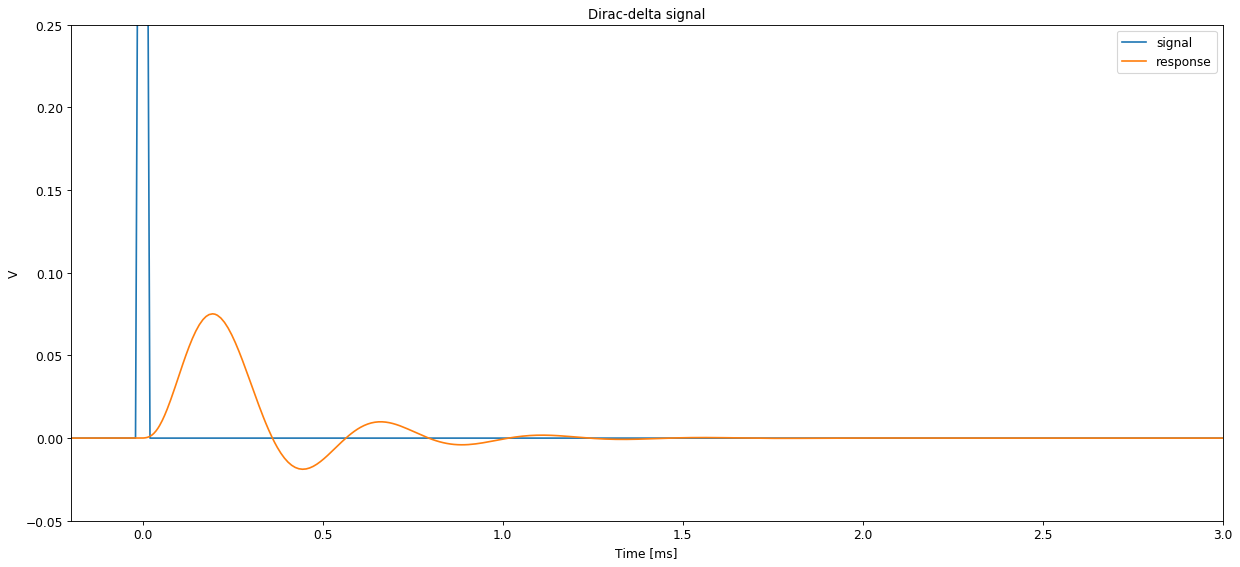

In [193]:
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')  
plt.title("Dirac-delta signal")
plt.plot(t_imp * 1e3, s_imp, label='signal')
plt.plot(t_imp * 1e3, r_imp, label='response')
plt.xlabel("Time [ms]")
plt.ylabel("V")
plt.ylim(-0.05,0.25)
plt.xlim(-.2,3)
plt.legend()

In [194]:
# Sáváteresztő szűrő impulzusválaszának Fourier-transzformáltja
r_imp_interp = interp1d(t_imp, r_imp, kind = 'linear')
s_imp_interp = interp1d(t_imp, s_imp, kind = 'linear')

tt = np.linspace(0,max(t_imp),1024)

fs = np.fft.rfft(s_imp_interp(tt))
fr = np.fft.rfft(r_imp_interp(tt))
freq = np.fft.rfftfreq(1024, tt[1] - tt[0])

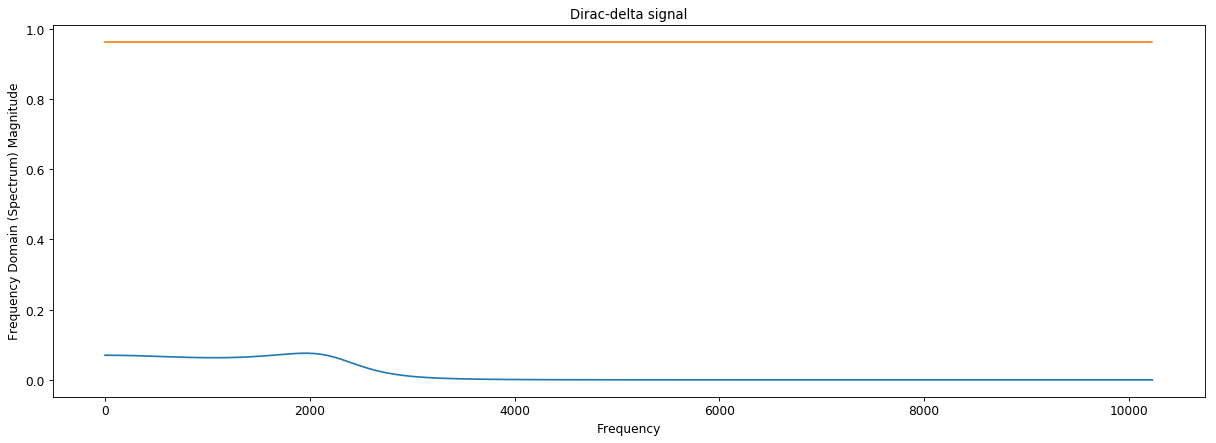

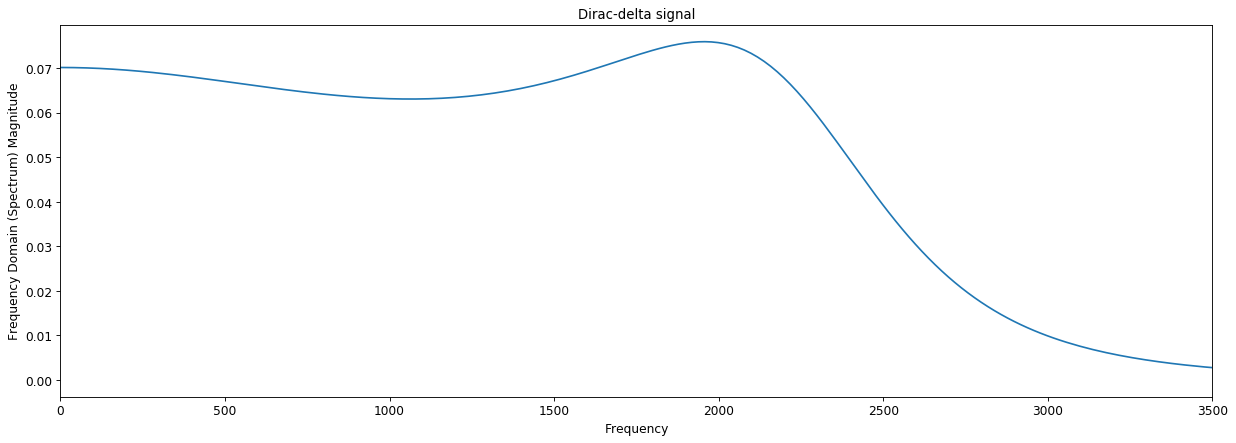

In [195]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Dirac-delta signal")
plt.xlabel('Frequency')
plt.ylabel('Frequency Domain (Spectrum) Magnitude')
plt.plot(freq, abs(fr)**2)
plt.plot(freq, abs(fs)**2)

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Dirac-delta signal")
plt.xlabel('Frequency')
plt.ylabel('Frequency Domain (Spectrum) Magnitude')
plt.xlim(0,3500)
plt.plot(freq, abs(fr)**2)

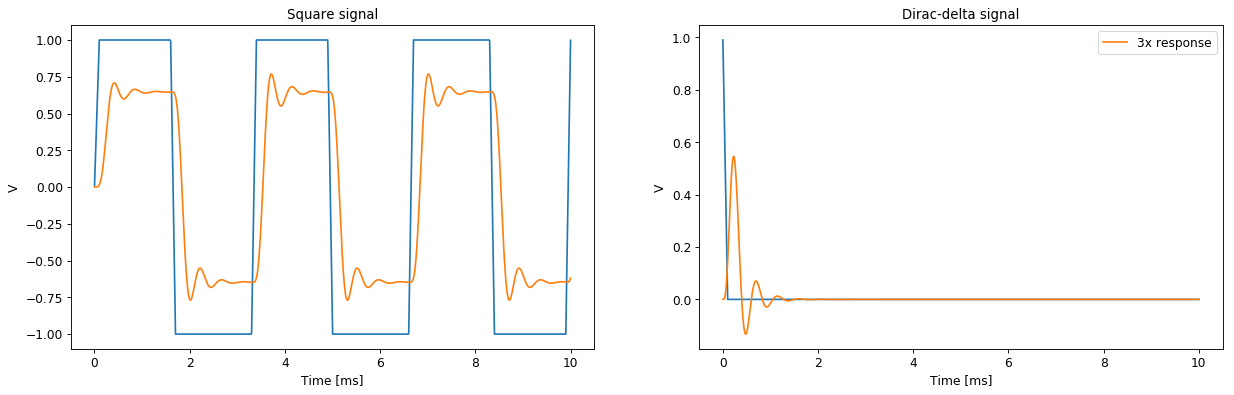

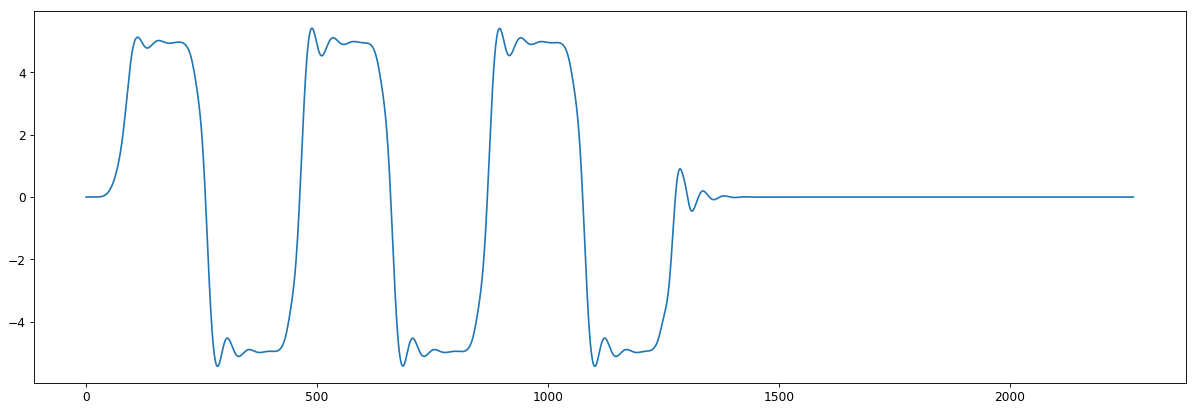

In [206]:
# Az impulzusválasz és a vizsgálójelek konvolúciójának meghatározása
c = butterworth_lowpass()

t = np.linspace(0,10,100000)

mero_negyszog_interp = interp1d(t,mero_negyszog(t, 1, 300), kind = 'linear')
mero_egysegimp_interp = interp1d(t,mero_egysegimp(t), kind = 'linear')

t_imp, s_imp, r_imp = run_transient(c, mero_egysegimp_interp, tstart=0, tstop=10e-3)
t_negyszog, s_negyszog, r_negyszog = run_transient(c, mero_negyszog_interp, tstart=0, tstop=10e-3)

plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')  
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

plt.subplot(2, 2, 1)
plt.title("Square signal")
plt.plot(t_negyszog * 1e3, s_negyszog)
plt.plot(t_negyszog * 1e3, r_negyszog)
plt.xlabel("Time [ms]")
plt.ylabel("V")

plt.subplot(2, 2, 2)
plt.title("Dirac-delta signal")
plt.plot(t_imp * 1e3, s_imp)
plt.plot(t_imp * 1e3, 3*r_imp, label='3x response')
plt.xlabel("Time [ms]")
plt.ylabel("V")
plt.legend()

# Láthatjuk, hogy az impulzus válaszával összekonvolváljuk a négyszögjelet, akkor
# megkapjuk a négyszög jel válaszát
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.convolve(r_imp, s_negyszog))

## 5. feladat - Zajok vizsgálata

Vizsgáljuk meg a sáváteresztő szűrő zaj jellegű gerjesztésre adott válaszát. Ehhez állítsunk elő ún. fehérzajt. A fehérzajt az jellemzi, hogy minden Fourier-komponense azonos amplitúdójú, de a komponensekhez tartozó fázisok véletlen eloszlásúak.

Ábrázoljuk a fehérzajt kinagyítva is, majd hasonlítsuk össze más, zaj jellegű függvényekke:

* uniform zaj: az időfüggő jel értéke egyenletes eloszlásból származik
* Poisson-zaj: az időfüggő jel értéke a Poisson-eloszlást követi

Határozzuk meg a sáváteresztő és az aluláteresztő szűrők válaszfüggvényét a fehérzajra. Vizsgáljuk meg a fehérzajra adott válasz Fourier-transzformáltját, és hasonlítsuk össze a hálózat átviteli függvényével.

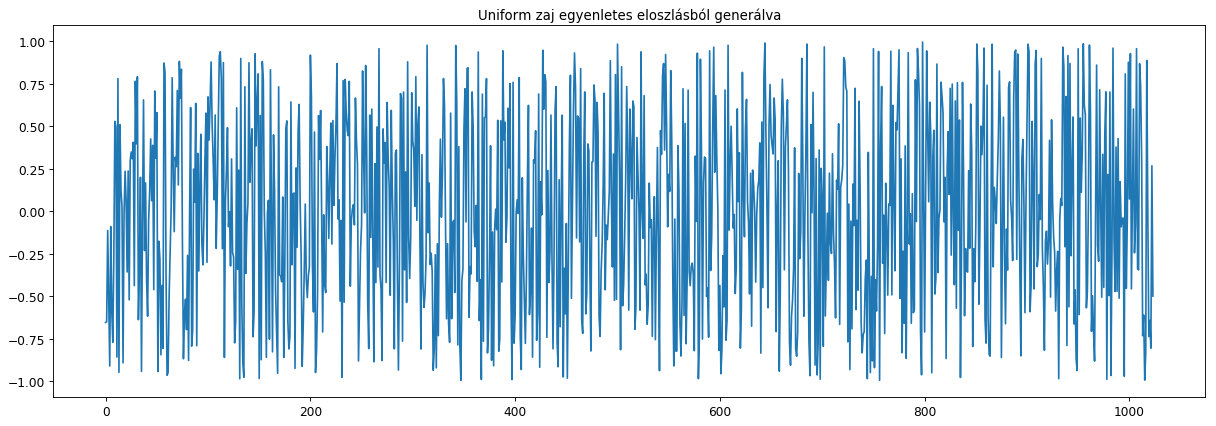

In [263]:
# Zaj egyenletes eloszlásból generálva
uniform_noise = np.random.uniform(-1024,1024,1024)/1024

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
title("Uniform zaj egyenletes eloszlásból generálva")
plt.plot(uniform_noise)

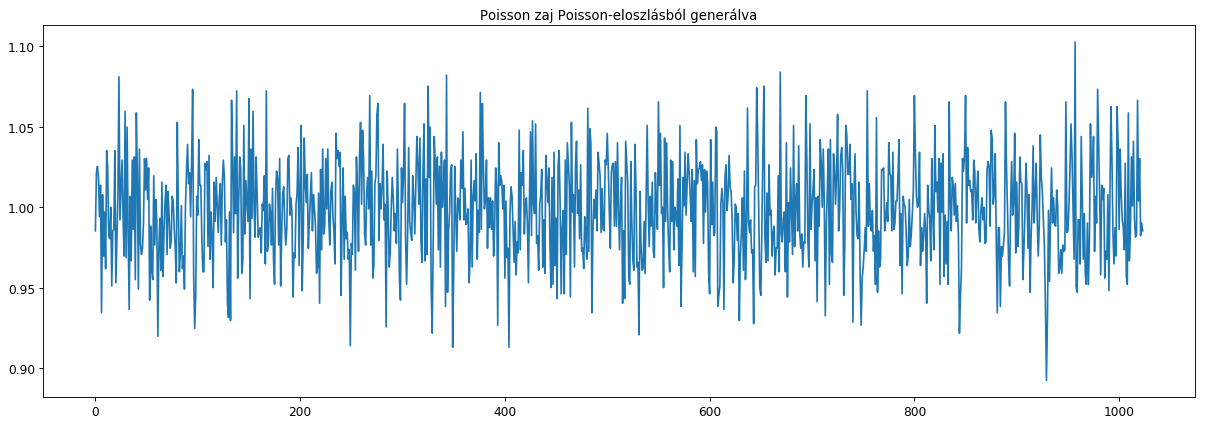

In [265]:
# Poisson-zaj előállítása
poission_noise = np.random.poisson(1024,1024)/1024

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
title("Poisson zaj Poisson-eloszlásból generálva")
plt.plot(poission_noise)

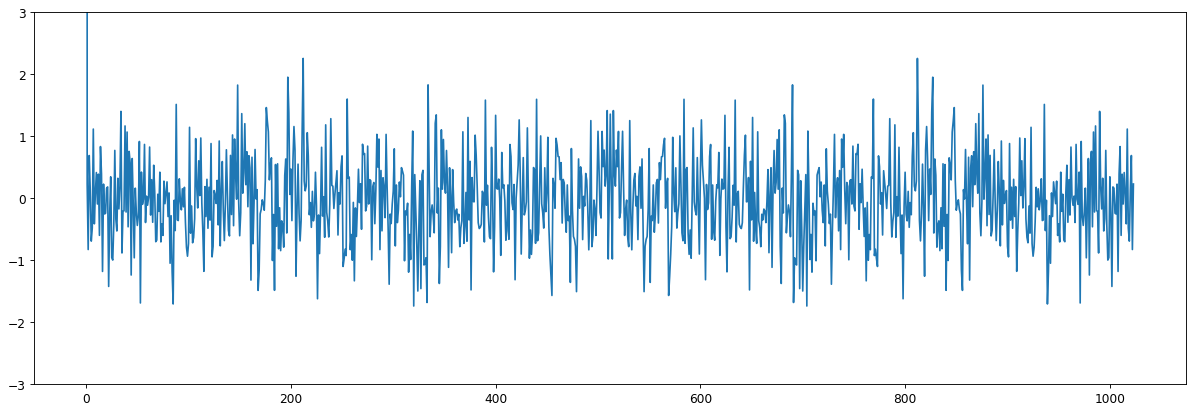

In [262]:
# Poisson-zaj Frourier-transzformáltja
fft_poisson_noise = np.fft.fft(poission_noise)

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
ylim(-3,3)
plot(fft_poisson_noise.real)

1.5657518677502905e-17

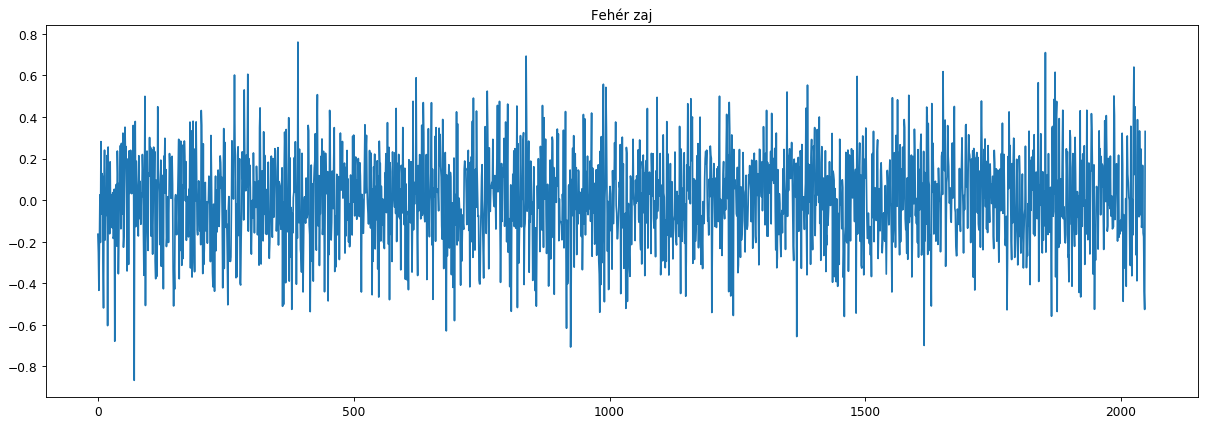

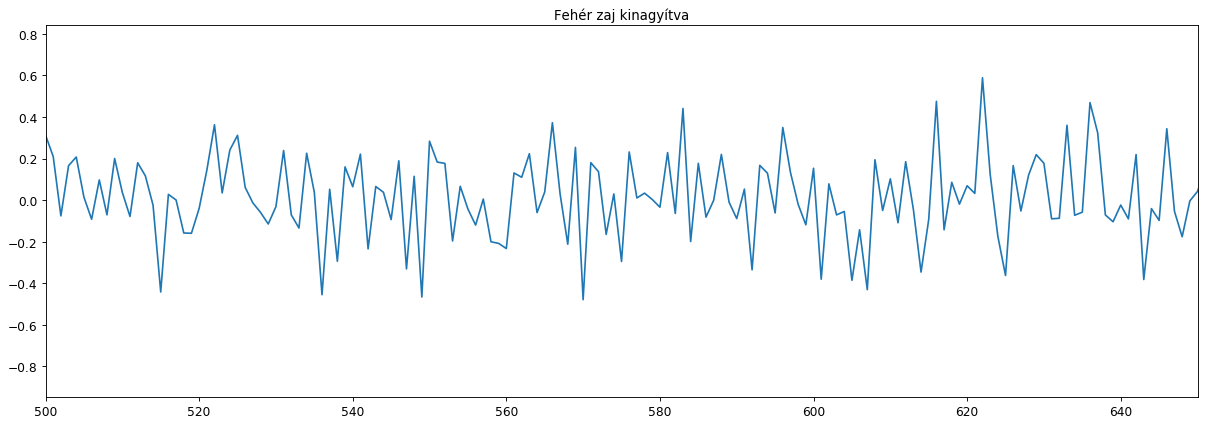

In [267]:
# Fehérzaj előállítása
fft_white_noise = exp(2*pi*rand(1023)*1j)
fft_white_noise_real = hstack([1, fft_white_noise, 1, conjugate(fft_white_noise[::-1])])
# Egyenletes eloszlásból származó zaj Fourier-transzformáltja
white_noise = 10*ifft(fft_white_noise_real)

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
title("Fehér zaj")
plt.plot(white_noise.real)

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
title("Fehér zaj kinagyítva")
plt.xlim(500,650)
plt.plot(white_noise.real)

abs(zaj.imag).max()

#### Second kind of white noise

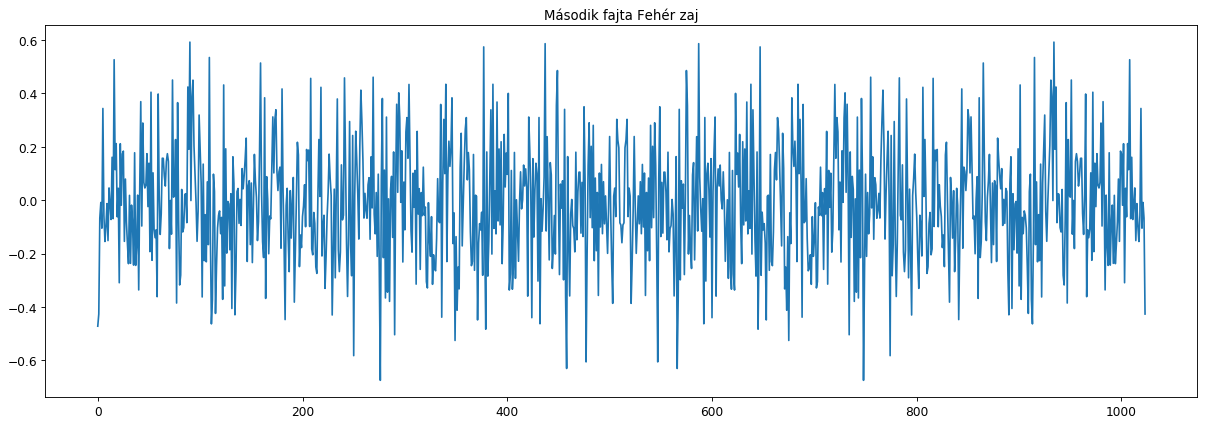

In [269]:
# Fehérzaj előállítása
mean = 0
std = 1 
fft_white_noise2 = np.random.normal(mean, std, size=1024)
# Egyenletes eloszlásból származó zaj Fourier-transzformáltja
white_noise2 = 10*ifft(fft_white_noise2)

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
title("Második fajta Fehér zaj")
plt.plot(white_noise2.real)

In [293]:
# Sáváteresztő szűrő fehérzajra adott válaszának meghatározása

def mero_white_noise2(t = 10000):
    fft_white_noise = exp(2*pi*rand(t)*1j)
    fft_white_noise_real = hstack([1, fft_white_noise, 1, conjugate(fft_white_noise[::-1])])
    # Egyenletes eloszlásból származó zaj Fourier-transzformáltja
    return 10*ifft(fft_white_noise_real)

def mero_white_noise2(t = 10000, mean = 0, std = 1):
    return numpy.random.normal(mean, std, size=t)

t = linspace(-1, 1, 10000)
mero_white_noise_interp = interp1d(t, mero_white_noise(len(t)), kind = 'linear')
mero_white_noise_interp2 = interp1d(t, mero_white_noise2(len(t)), kind = 'linear')

c = butterworth_bandpass()
t_white, s_white, r_white = run_transient(c, mero_white_noise_interp, tstart=0, tstop=10e-2)
t_white2, s_white2, r_white2 = run_transient(c, mero_white_noise_interp2, tstart=0, tstop=10e-2)

Text(0, 0.5, 'V')

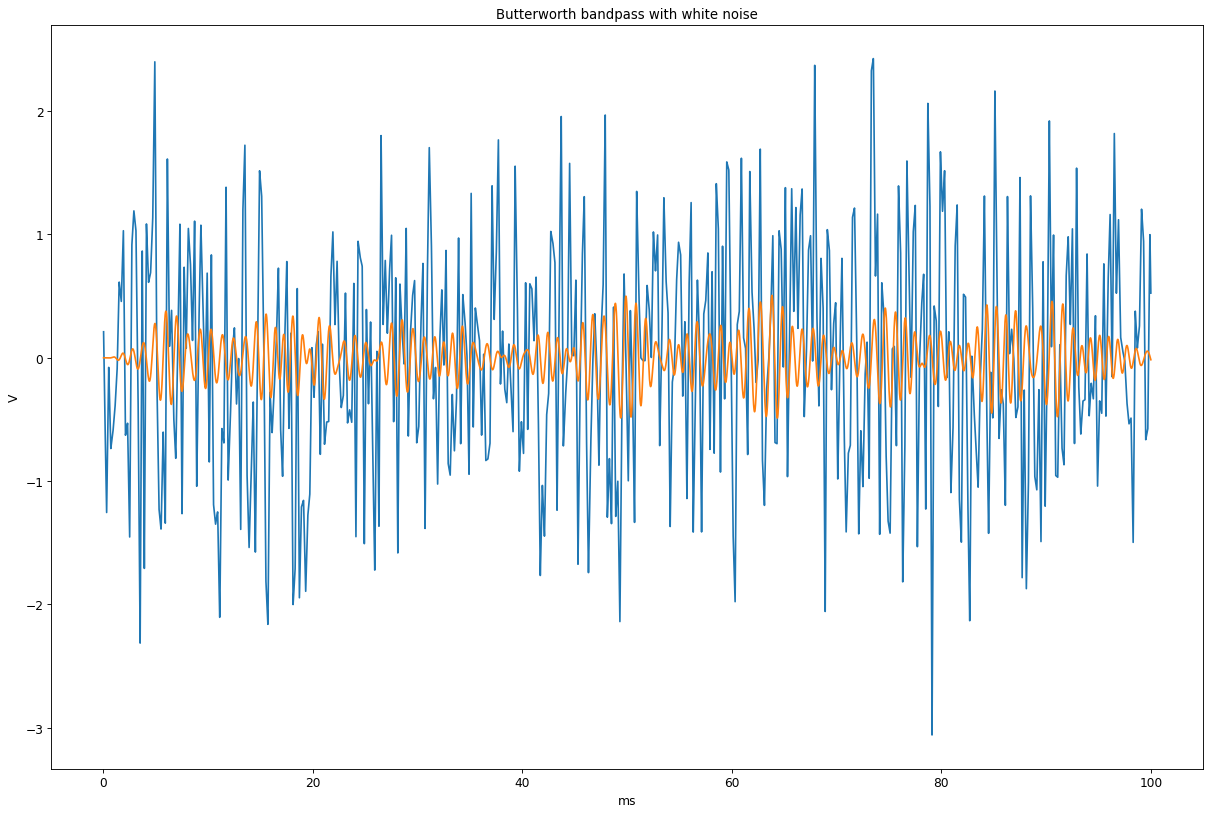

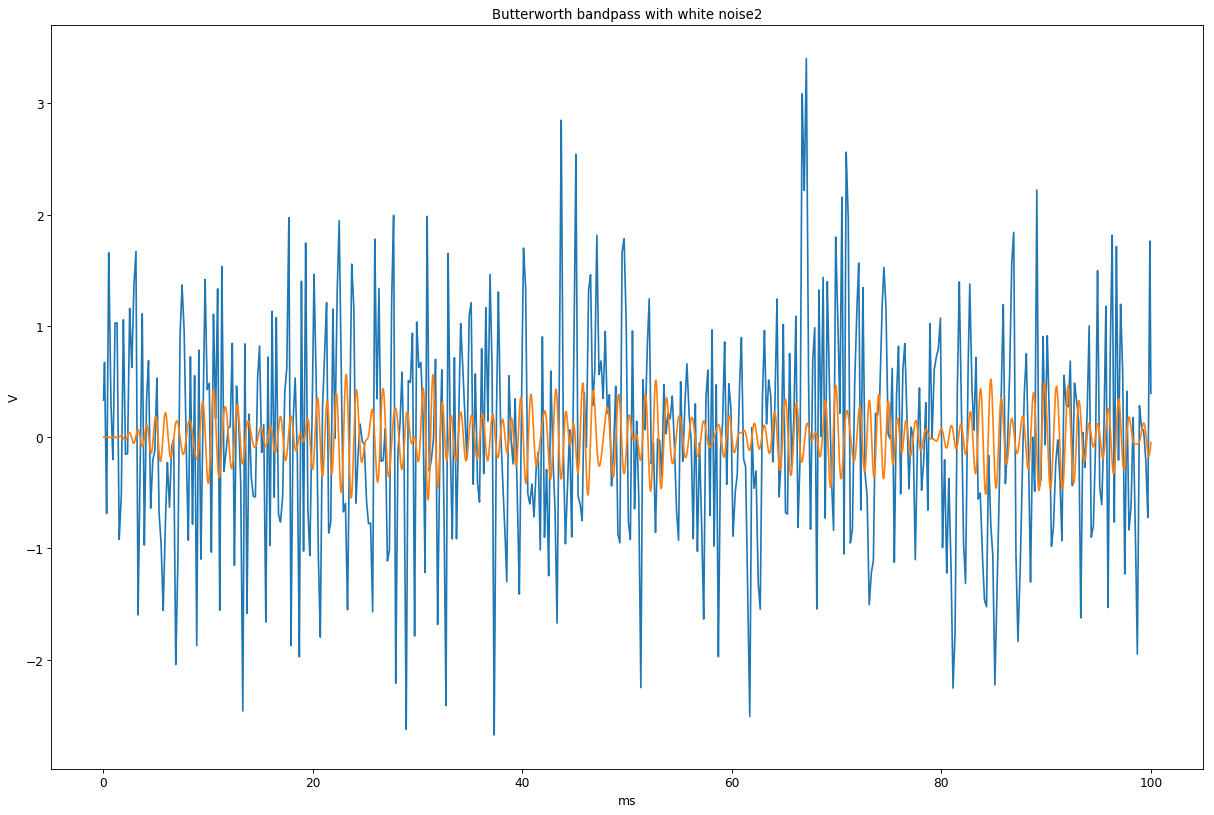

In [294]:
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k') 
title("Butterworth bandpass with white noise")
plt.plot(t_white * 1e3, s_white)
plt.plot(t_white * 1e3, r_white)
plt.xlabel("ms")
plt.ylabel("V")
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k') 
title("Butterworth bandpass with white noise2")
plt.plot(t_white2 * 1e3, s_white2)
plt.plot(t_white2 * 1e3, r_white2)
plt.xlabel("ms")
plt.ylabel("V")

(-1, 20)

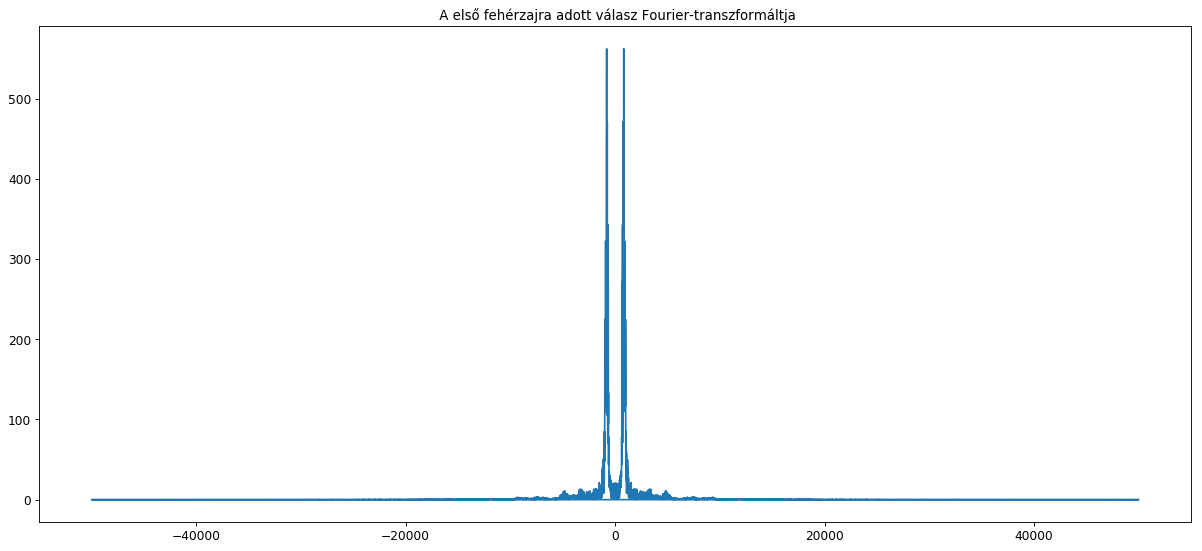

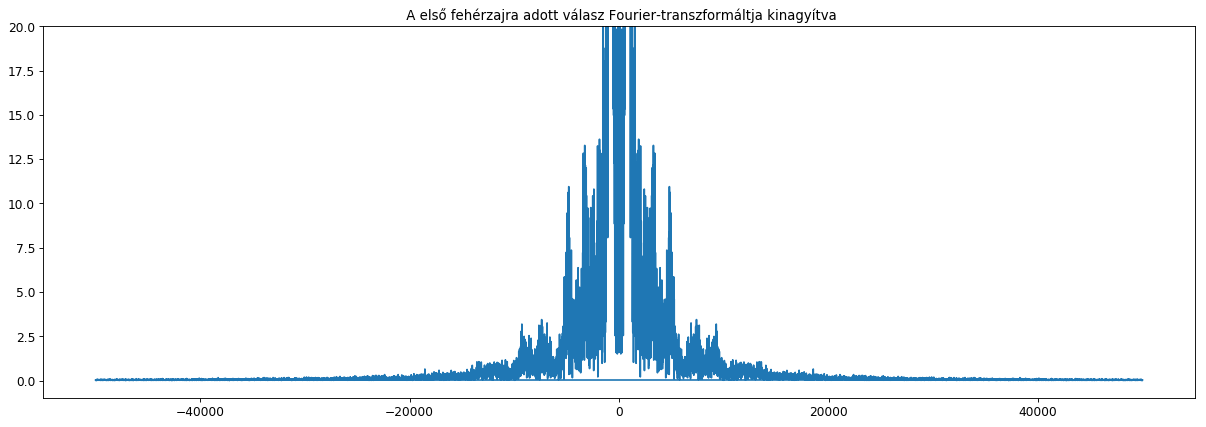

In [300]:
# A első fehérzajra adott válasz Fourier-transzformáltja

figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='r')  
title(" A első fehérzajra adott válasz Fourier-transzformáltja")
frwhite=np.fft.fft(r_white)
freq = fftfreq(len(t_white),t_white[1]-t_white[0])
plot(freq,abs(frwhite))
#xlim(-20000,20000)

figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='r')  
title(" A első fehérzajra adott válasz Fourier-transzformáltja kinagyítva")
frwhite=np.fft.fft(r_white)
freq = fftfreq(len(t_white),t_white[1]-t_white[0])
plot(freq,abs(frwhite))
ylim(-1,20)


(-1, 20)

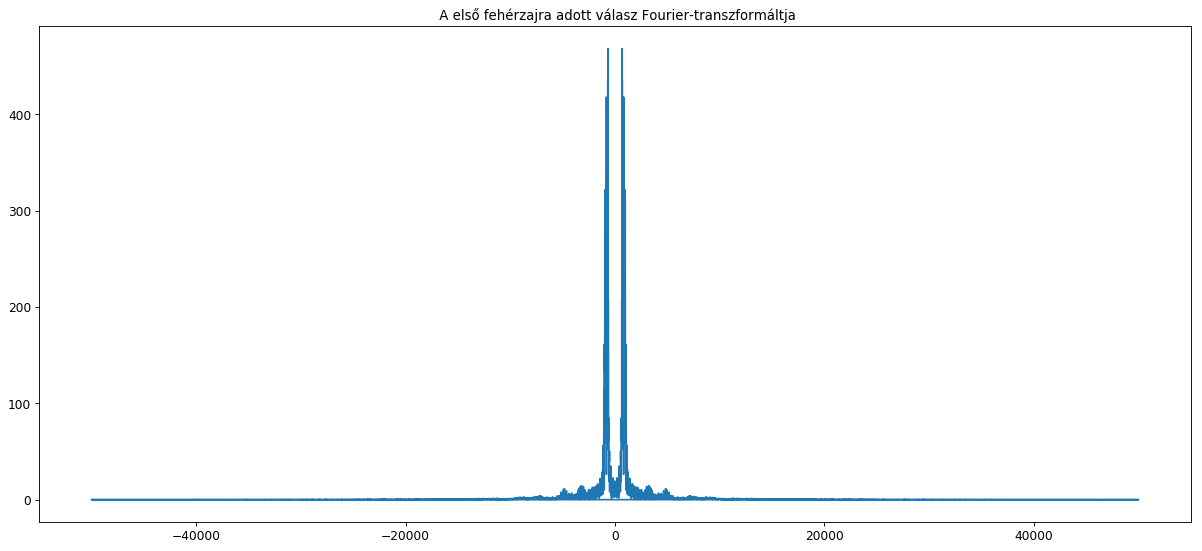

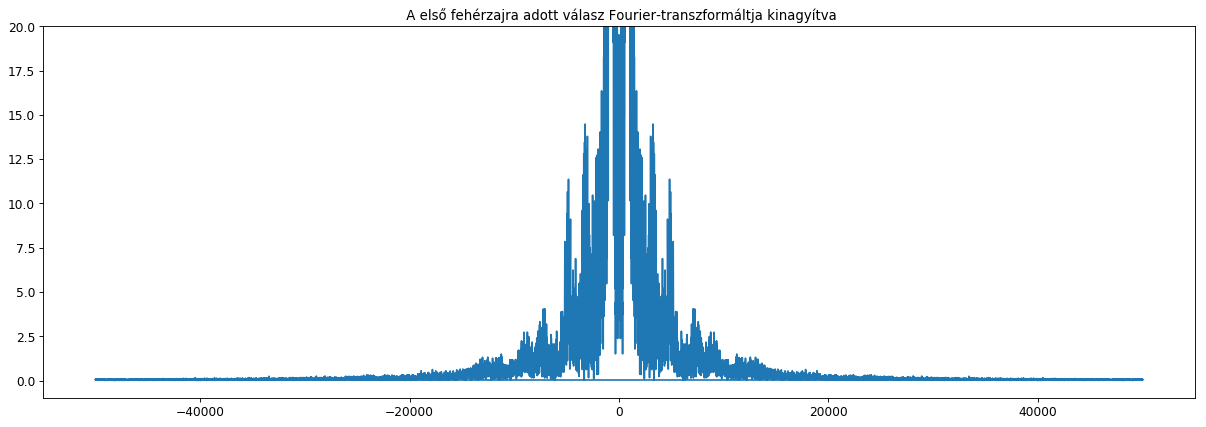

In [301]:
# A első fehérzajra adott válasz Fourier-transzformáltja

figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='r')  
title(" A első fehérzajra adott válasz Fourier-transzformáltja")
frwhite2=np.fft.fft(r_white2)
freq2 = fftfreq(len(t_white2),t_white2[1]-t_white2[0])
plot(freq2,abs(frwhite2))
#xlim(-20000,20000)

figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='r')  
title(" A első fehérzajra adott válasz Fourier-transzformáltja kinagyítva")
frwhite2=np.fft.fft(r_white2)
freq2 = fftfreq(len(t_white2),t_white2[1]-t_white2[0])
plot(freq2,abs(frwhite2))
ylim(-1,20)
